In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np


file_path = 'downsampled_data/S100_processed.csv'
df = pd.read_csv(file_path)


participant = df["participant_id"].unique()
print(participant)
display(df.head())

['S100']


,participant_id,window_start_time,window_end_time,sleep_stage,BVP_mean,BVP_std,BVP_min,BVP_max,BVP_range,BVP_median,...,EDA_mean,EDA_std,EDA_trend,TEMP_mean,TEMP_std,TEMP_slope,HR_mean,HR_std,HR_range,HR_trend
0,S100,6183.0,6212.984375,W,0.045375,26.461452,-117.58,108.20,225.78,0.670,...,0.160953,0.002683,0.000004,32.152000,0.007483,0.000007,74.139667,0.609150,2.53,0.000774
1,S100,6213.0,6242.984375,W,0.146734,43.980191,-230.11,300.71,530.82,-0.775,...,0.167922,0.002815,0.000005,32.171667,0.010355,0.000013,75.699000,0.572674,1.92,-0.000826
2,S100,6243.0,6272.984375,W,-0.334979,19.530235,-63.33,38.98,102.31,0.380,...,0.175276,0.001853,0.000003,32.169000,0.010440,-0.000007,74.246000,0.173043,0.83,0.000010
3,S100,6273.0,6302.984375,W,0.220146,16.685756,-54.72,34.11,88.83,1.165,...,0.179845,0.001530,0.000002,32.166000,0.012806,-0.000004,72.990333,0.241240,0.90,-0.000021
4,S100,6303.0,6332.984375,W,-0.225391,16.808485,-52.94,45.28,98.22,1.770,...,0.183633,0.001781,0.000003,32.157667,0.008825,-0.000005,73.011000,0.301810,0.92,-0.000535


/tmp/ipykernel_431379/3302837800.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


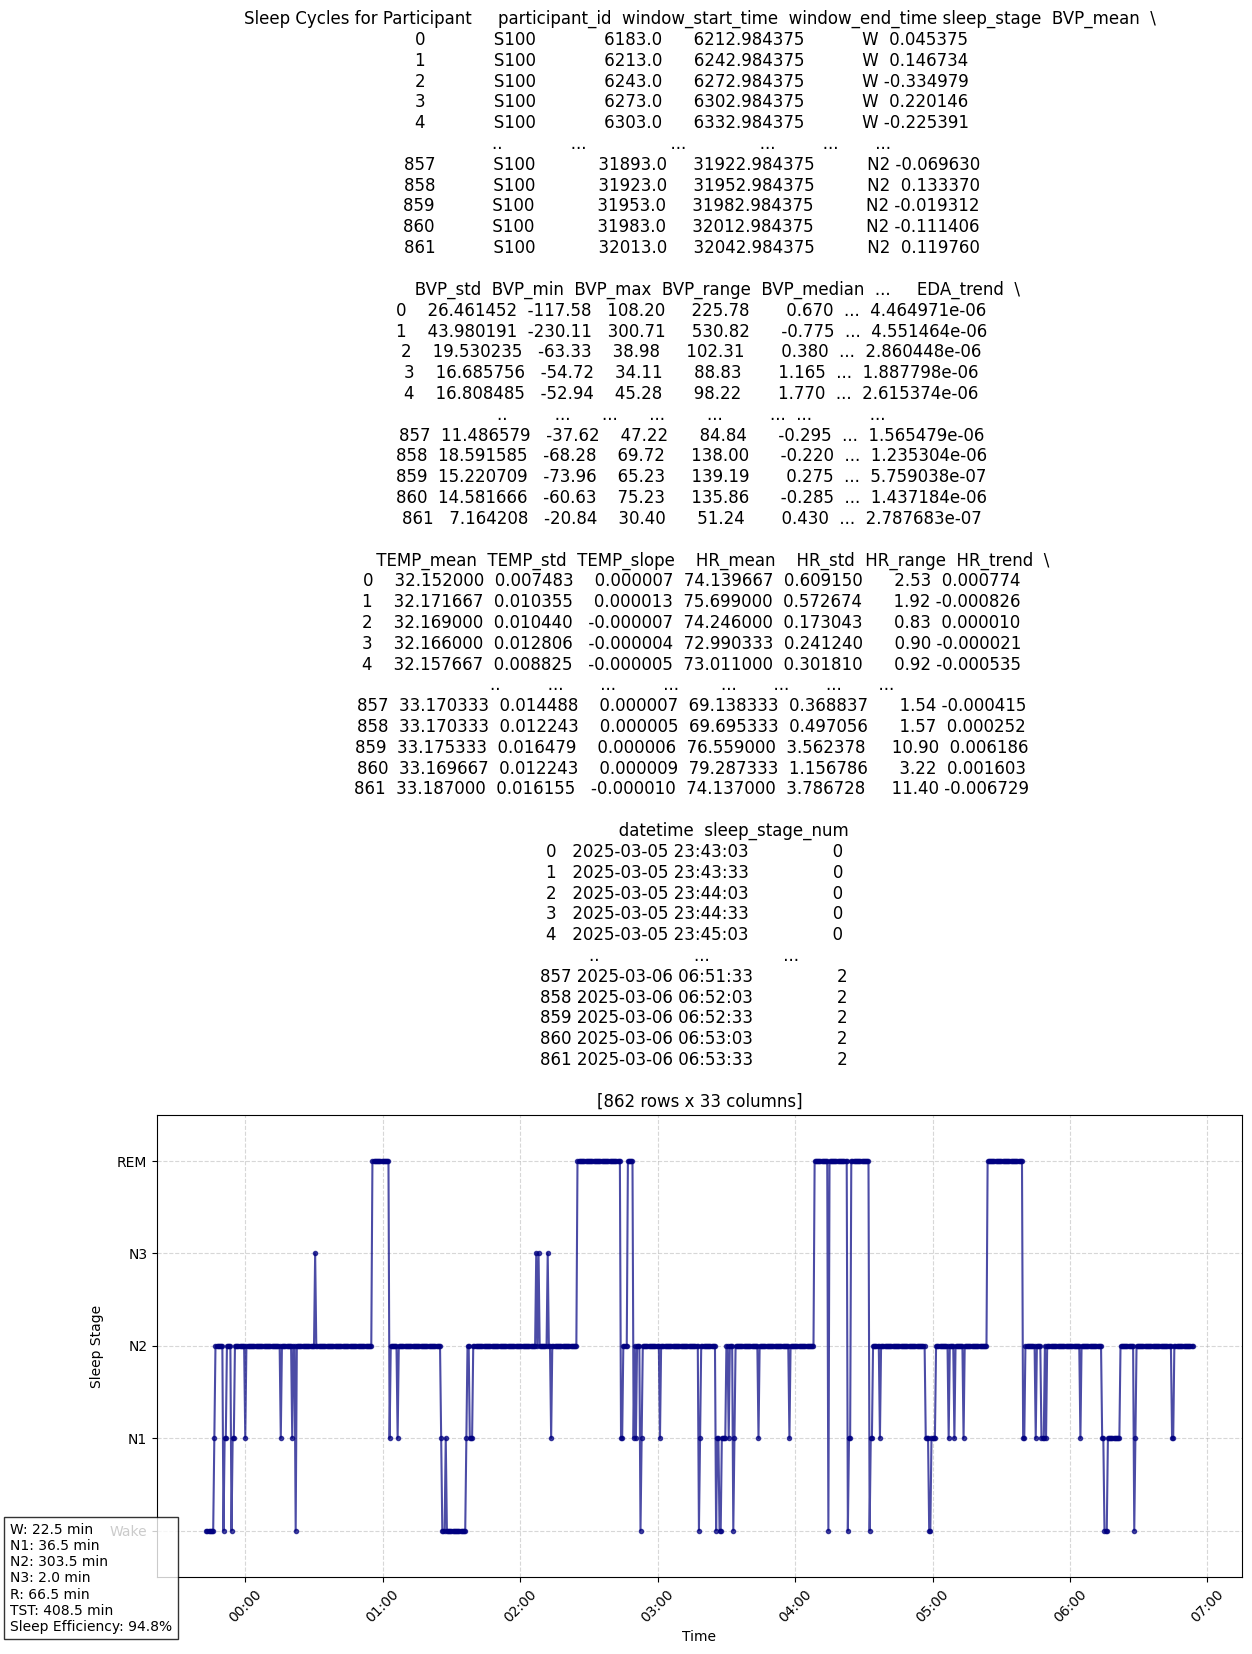

In [4]:
# Convert time columns to datetime if they aren't already
# For this example, we'll use window_start_time as seconds from the beginning of recording
base_time = datetime.now().replace(hour=22, minute=0, second=0, microsecond=0) - timedelta(days=1)
df['datetime'] = df['window_start_time'].apply(
    lambda x: base_time + timedelta(seconds=float(x))
)

# Map sleep stages to numeric values for plotting
sleep_stage_map = {
    'W': 0,   # Wake
    'N1': 1,  # NREM 1 (light sleep)
    'N2': 2,  # NREM 2 (light sleep)
    'N3': 3,  # NREM 3 (deep sleep)
    'R': 4    # REM sleep
}

# Convert sleep stages to numeric values
df['sleep_stage_num'] = df['sleep_stage'].map(sleep_stage_map)

# Create the plot
plt.figure(figsize=(14, 6))

# Plot sleep stages
plt.plot(df['datetime'], df['sleep_stage_num'], 
            marker='.', linestyle='-', color='navy', alpha=0.7)

# Customize x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Customize y-axis
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim(-0.5, 4.5)

# Add grid for better readability
plt.grid(True, which='major', axis='both', linestyle='--', alpha=0.5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Sleep Stage')
plt.title(f'Sleep Cycles for Participant {df}')

# Add statistics
stats_text = []

# Calculate duration of each sleep stage
stage_durations = {}
for stage in sleep_stage_map.keys():
    stage_count = len(df[df['sleep_stage'] == stage])
    # Each window is 30 seconds
    duration_mins = stage_count * 30 / 60
    stage_durations[stage] = duration_mins
    stats_text.append(f"{stage}: {duration_mins:.1f} min")

# Calculate total sleep time (TST)
tst = sum([v for k, v in stage_durations.items() if k != 'W'])
stats_text.append(f"TST: {tst:.1f} min")

# Add sleep efficiency (time asleep / time in bed)
total_time = sum(stage_durations.values())
sleep_efficiency = (tst / total_time) * 100 if total_time > 0 else 0
stats_text.append(f"Sleep Efficiency: {sleep_efficiency:.1f}%")

# Add stats to the plot
plt.figtext(0.02, 0.02, '\n'.join(stats_text), fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [15]:
import os

data_folder = 'downsampled_data'
file_pattern = '*.csv'
file_paths = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.csv')]

# Initialize empty list to store dataframes
all_data = []

# Load each participant's data
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        # Add file name as a feature to track the source
        df['file_source'] = os.path.basename(file_path)
        all_data.append(df)
        # print(f"Loaded {file_path} with {len(df)} rows")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Combine all data
if not all_data:
    raise ValueError("No data was loaded. Check file paths and formats.")

combined_data = pd.concat(all_data, ignore_index=True)
print(f"Combined data shape: {combined_data.shape}")
print(combined_data.columns)
print(combined_data['sleep_stage'].unique())

Combined data shape: (42114, 32)
Index(['participant_id', 'window_start_time', 'window_end_time', 'sleep_stage',
       'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max', 'BVP_range', 'BVP_median',
       'SDNN', 'median_nni', 'IBI_mean', 'x_std', 'y_std', 'z_std', 'mag_mean',
       'mag_std', 'mag_max', 'movement_density', 'burst_count', 'EDA_mean',
       'EDA_std', 'EDA_trend', 'TEMP_mean', 'TEMP_std', 'TEMP_slope',
       'HR_mean', 'HR_std', 'HR_range', 'HR_trend', 'file_source'],
      dtype='object')
['W' 'N2' 'N1' 'R' 'N3' 'Missing']


In [16]:
print(combined_data.shape)
print((combined_data["sleep_stage"] == "R").sum())
print(combined_data['sleep_stage'].unique())
combined_data = combined_data[combined_data['sleep_stage'].isin(['W', 'N1', 'N2', 'R'])] # dont keep N3, Missing, P, but everything else
print(combined_data.shape)
display(combined_data.head())

(42114, 32)
4216
['W' 'N2' 'N1' 'R' 'N3' 'Missing']
(41042, 32)


,participant_id,window_start_time,window_end_time,sleep_stage,BVP_mean,BVP_std,BVP_min,BVP_max,BVP_range,BVP_median,...,EDA_std,EDA_trend,TEMP_mean,TEMP_std,TEMP_slope,HR_mean,HR_std,HR_range,HR_trend,file_source
0,S002,9174.0,9203.984375,W,2.910635,156.689374,-1257.38,705.59,1962.97,2.345,...,0.001109,4.324480e-07,32.096000,0.011719,-0.000010,76.942333,2.182469,7.90,0.003921,S002_processed.csv
1,S002,9204.0,9233.984375,W,-2.742552,123.765146,-749.06,472.29,1221.35,0.170,...,0.001096,9.699156e-08,32.084667,0.012579,0.000006,83.393333,1.340396,4.07,0.002190,S002_processed.csv
2,S002,9234.0,9263.984375,W,-0.284318,53.208641,-196.70,153.36,350.06,2.980,...,0.001045,-1.228833e-07,32.121000,0.024678,0.000038,81.851333,0.555168,2.33,-0.000489,S002_processed.csv
3,S002,9264.0,9293.984375,W,-0.001896,76.945045,-369.24,242.02,611.26,4.325,...,0.000996,-3.064638e-07,32.209000,0.036088,0.000061,82.738000,0.594981,2.35,0.000870,S002_processed.csv
4,S002,9294.0,9323.984375,W,-0.880448,154.357977,-572.48,620.29,1192.77,6.830,...,0.001019,5.136069e-08,32.307667,0.031378,0.000051,86.277000,1.170117,4.17,-0.000491,S002_processed.csv


In [17]:
print(combined_data['sleep_stage'].unique())

['W' 'N2' 'N1' 'R']


Training set size: (32833, 27)
Test set size: (8209, 27)
Training SVM model with predefined hyperparameters and class balancing...
Test accuracy: 0.5202
              precision    recall  f1-score   support

          N1       0.22      0.34      0.27       952
          N2       0.74      0.52      0.61      4066
           R       0.28      0.69      0.40       843
           W       0.68      0.53      0.60      2348

    accuracy                           0.52      8209
   macro avg       0.48      0.52      0.47      8209
weighted avg       0.62      0.52      0.55      8209



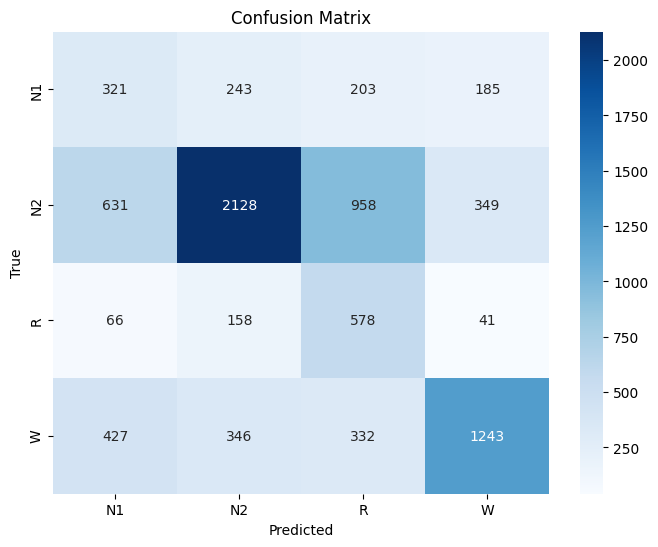

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# features to drop
exclude_cols = ['participant_id', 'window_start_time', 'window_end_time', 
                'sleep_stage', 'file_source', 'datetime', 'sleep_stage_num']

# drop columns
X = combined_data.drop(columns=[col for col in exclude_cols if col in combined_data.columns])
y = combined_data['sleep_stage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

def train_sleep_svm(X_train, y_train, X_test, y_test, test_size=0.2, random_state=42):
    # Create a pipeline with standardization and SVM with class balancing
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, C=1, gamma='scale', kernel='rbf', class_weight='balanced'))  # Class balancing added
    ])
    
    # Train the model
    print("Training SVM model with predefined hyperparameters and class balancing...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model on test data
    accuracy = pipeline.score(X_test, y_test)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Return the trained model
    return pipeline, X_test, y_test

# Train SVM model with class balancing
model, X_test, y_test = train_sleep_svm(X_train, y_train, X_test, y_test, test_size=0.2, random_state=42)

# Optionally print classification report and confusion matrix
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(combined_data['sleep_stage'].value_counts())

sleep_stage
N2    20327
W     11738
N1     4761
R      4216
Name: count, dtype: int64


Training set size: (32833, 27)
Test set size: (8209, 27)
Training SVM model with predefined hyperparameters and class balancing...
Test accuracy: 0.5086
              precision    recall  f1-score   support

          N1       0.22      0.33      0.26       952
          N2       0.72      0.52      0.60      4066
           R       0.27      0.67      0.38       843
           W       0.67      0.51      0.58      2348

    accuracy                           0.51      8209
   macro avg       0.47      0.51      0.46      8209
weighted avg       0.60      0.51      0.53      8209



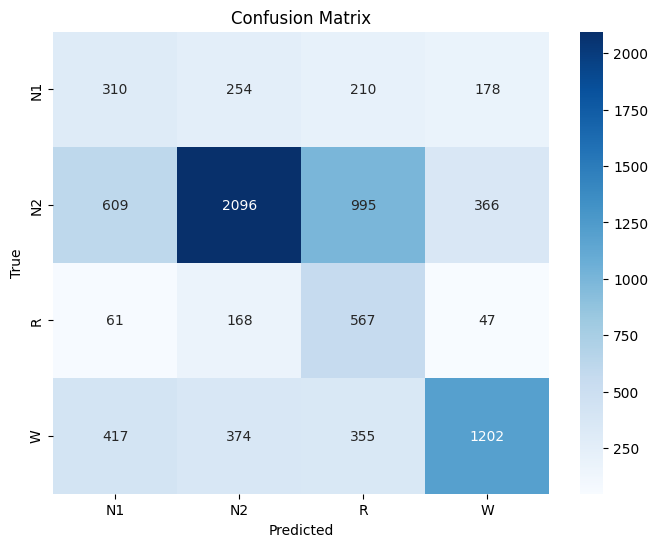

In [21]:
from imblearn.under_sampling import RandomUnderSampler

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Perform class balancing using RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={
    'N2': min(X_train[y_train == 'N2'].shape[0], 7000),  # Limit N2 samples to 7000
    'W': min(X_train[y_train == 'W'].shape[0], 7000),  # Limit Wake samples to 7000
    'N1': min(X_train[y_train == 'N1'].shape[0], 4000),  # Limit N1 samples to 4000 (adjust as needed)
    'R': min(X_train[y_train == 'R'].shape[0], 4000)   # Limit R samples to 4000 (adjust as needed)
}, random_state=42)

# Apply the resampling to balance the dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train SVM model with class balancing
model, X_test, y_test = train_sleep_svm(X_train_resampled, y_train_resampled, X_test, y_test, test_size=0.2, random_state=42)

# Optionally print classification report and confusion matrix
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Set up RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Define the SVM pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, C=1, gamma='scale', kernel='rbf'))  # No class balancing needed here
])

# Cross-validation loop
for train_index, val_index in skf.split(X_train, y_train):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Apply RandomUnderSampler on training data only
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_fold, y_train_fold)
    
    # Train the model on the resampled data
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"Fold accuracy: {accuracy:.4f}")


Fold accuracy: 0.4918
Fold accuracy: 0.4982
Fold accuracy: 0.5035
Fold accuracy: 0.4943
